In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.metropolishastings import MetropolisHastings
from utils.state import State
from utils.drawing import discrete_inverse_trans, \
    transform_into_marginals_clean, DFconditional, draw_from_marginals
from utils.age_category_marija import age_category, age_mother_cat, age_category_5, age_category_5_shifted
from utils.statistical_assessments import stats_assessment
from joblib import Parallel, delayed, cpu_count
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import uniform
from scipy.stats import norm
import copy
import warnings
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import pickle
import tikzplotlib
#from matplotlib2tikz import save as tikz_save
from datetime import datetime
from matplotlib.cm import get_cmap
import os
print(matplotlib.__version__)
import tikzplotlib
warnings.filterwarnings("ignore")

3.3.3


In [2]:
%load_ext autoreload
%autoreload 2

### Low high scenario

In [27]:
data_hh_2015_high = pd.read_csv('data/hh_rw_2015.csv')
data_indiv_2015_high = pd.read_csv('data/indiv_rw_2015.csv')

projected_data = pd.read_csv('results/quality_samples/projection_2010_2015_low_both.csv')

for df in [data_hh_2015_high, projected_data]:
    df['hsize_new'] = df['hsize'].apply(lambda x: x if x < 6 else 6)

# Group by hsize_new and count occurrences
combinations_projected = projected_data.groupby("hsize_new").size().reset_index(name="Counts_projected")
combinations_real = data_hh_2015_high.groupby("hsize_new").size().reset_index(name="Counts_real")

# Merge using outer join on hsize_new
merged_df = pd.merge(combinations_projected, combinations_real, on="hsize_new", how="outer")

# Fill missing values with 0
merged_df["Counts_projected"] = merged_df["Counts_projected"].fillna(0).astype(int)
merged_df["Counts_real"] = merged_df["Counts_real"].fillna(0).astype(int)

# Calculate total counts
total_counts_projected = merged_df["Counts_projected"].sum()
total_counts_real = merged_df["Counts_real"].sum()

# Add probability columns
merged_df["Prob_projected"] = merged_df["Counts_projected"] / total_counts_projected
merged_df["Prob_real"] = merged_df["Counts_real"] / total_counts_real

# Display the result
print(merged_df)

   hsize_new  Counts_projected  Counts_real  Prob_projected  Prob_real
0          1             15329        19375        0.954186   0.154577
1          2               365        40412        0.022720   0.322414
2          3               102        22050        0.006349   0.175919
3          4               176        27812        0.010955   0.221889
4          5                81        10260        0.005042   0.081856
5          6                12         5433        0.000747   0.043345


### High low scenario

In [20]:
import pandas as pd

# Load datasets
data_hh_2015_high = pd.read_csv('data/hh_rw_2015.csv')
data_indiv_2015_high = pd.read_csv('data/indiv_rw_2015.csv')

# Filter for single households (hsize == 1)
data_hh_2015_low = data_hh_2015_high[data_hh_2015_high['hsize'] == 1]
data_indiv_2015_low = data_indiv_2015_high[data_indiv_2015_high['hsize'] == 1]

# Load projected data
projected_2010_2015 = pd.read_csv("projected_2010_2015_second_paper_high.csv")

# Create 'hsize_new' column (group sizes 6 or more under 6)
for df in [data_hh_2015_low, projected_2010_2015]:
    df['hsize_new'] = df['hsize'].apply(lambda x: x if x < 6 else 6)

# Group by hsize_new and count occurrences
combinations_projected = projected_2010_2015.groupby("hsize_new").size().reset_index(name="Counts_projected")
combinations_real = data_hh_2015_low.groupby("hsize_new").size().reset_index(name="Counts_real")

# Merge using outer join on hsize_new
merged_df = pd.merge(combinations_projected, combinations_real, on="hsize_new", how="outer")

# Fill missing values with 0
merged_df["Counts_projected"] = merged_df["Counts_projected"].fillna(0).astype(int)
merged_df["Counts_real"] = merged_df["Counts_real"].fillna(0).astype(int)

# Calculate total counts
total_counts_projected = merged_df["Counts_projected"].sum()
total_counts_real = merged_df["Counts_real"].sum()

# Add probability columns
merged_df["Prob_projected"] = merged_df["Counts_projected"] / total_counts_projected
merged_df["Prob_real"] = merged_df["Counts_real"] / total_counts_real

# Display the result
print(merged_df)


   hsize_new  Counts_projected  Counts_real  Prob_projected  Prob_real
0          1             23289        19375        0.158942        1.0
1          2             43942            0        0.299894        0.0
2          3             26199            0        0.178802        0.0
3          4             33596            0        0.229285        0.0
4          5             14245            0        0.097219        0.0
5          6              5254            0        0.035857        0.0


### Low - low scenario

In [3]:
#synthetic_2010 = pd.read_csv("synthetic_households_2010.csv")

data_hh_2010_high = pd.read_csv('data/hh_rw_2010.csv')
data_indiv_2010_high = pd.read_csv('data/indiv_rw_2010.csv')
data_hh_2015_high = pd.read_csv('data/hh_rw_2015.csv')
data_indiv_2015_high = pd.read_csv('data/indiv_rw_2015.csv')

reference_data_2010 = data_hh_2010_high[data_hh_2010_high['hsize']==1]
reference_data_2010_indiv = data_indiv_2010_high[data_indiv_2010_high['hsize']==1]

reference_data_2015 = data_hh_2015_high[data_hh_2015_high['hsize']==1]
reference_data_2015_indiv = data_indiv_2015_high[data_indiv_2015_high['hsize']==1]

In [5]:
combinations_projected = reference_data_2010.groupby(["hsize"]).size().reset_index(name='Count')
combinations_real = reference_data_2015.groupby(["hsize"]).size().reset_index(name='Count')

In [7]:
merged_df = pd.merge(combinations_projected, combinations_real, on=["hsize"], how='inner')
merged_df = merged_df.rename(columns={'Count_x': 'Counts_projected', 'Count_y': 'Counts_real'})

In [8]:
total_counts_projected = merged_df['Counts_projected'].sum()
total_counts_real = merged_df['Counts_real'].sum()

# Calculate probabilities
merged_df['Prob_projected'] = merged_df['Counts_projected'] / total_counts_projected
merged_df['Prob_real'] = merged_df['Counts_real'] / total_counts_real

In [9]:
merged_df

,hsize,Counts_projected,Counts_real,Prob_projected,Prob_real
0,1,17400,19375,1.0,1.0


In [ ]:
#1975 -> ovo je trivijalno resenje, ne moram da racunam frequencies

### Normal case study

In [5]:
#synthetic_2010 = pd.read_csv("synthetic_households_2010.csv")

reference_data_2010 = pd.read_csv("hh_rw_2010.csv")
reference_data_2015 = pd.read_csv("hh_rw_2015.csv")

reference_data_2010_indiv = pd.read_csv("data/indiv_rw_2010.csv")
reference_data_2015_indiv = pd.read_csv("data/indiv_rw_2015.csv")

projection_2010_2015 = pd.read_csv("results/proj2/predictive_sample_2015.csv")
projection_2010_2021 = pd.read_csv("results/proj3/predictive_sample_2021.csv")

reference_data_2015['hsize_new'] = reference_data_2015.hsize.apply(lambda x: 6 if x >= 6 else x)
projection_2010_2015['hsize_new'] = projection_2010_2015.hsize.apply(lambda x: 6 if x >= 6 else x)

In [4]:
reference_data_2015

,hid,hhweight,role,age,gender,driving_licence,age_discrete,nind,total_num_licences,hsize,htype,nbcars,hhincome,nbcars_agg,hsize_new
0,0,1.652601,1,41,1,1,4,4,1,4,220,2,7,2,4
1,0,1.652601,2,39,2,2,4,4,1,4,220,2,7,2,4
2,0,1.652601,3,14,2,2,1,4,1,4,220,2,7,2,4
3,0,1.652601,4,12,1,2,1,4,1,4,220,2,7,2,4
4,1,1.093420,1,30,1,1,4,1,1,1,10,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125637,56769,0.322243,2,54,2,1,5,4,2,4,220,2,7,2,4
125638,56769,0.322243,3,21,2,2,3,4,2,4,220,2,7,2,4
125639,56769,0.322243,4,19,2,2,3,4,2,4,220,2,7,2,4
125640,56770,5.551432,1,27,2,1,4,1,1,1,10,1,3,1,1


In [5]:
reference_data_2015[reference_data_2015['hsize_new']==4]

,hid,hhweight,role,age,gender,driving_licence,age_discrete,nind,total_num_licences,hsize,htype,nbcars,hhincome,nbcars_agg,hsize_new
0,0,1.652601,1,41,1,1,4,4,1,4,220,2,7,2,4
1,0,1.652601,2,39,2,2,4,4,1,4,220,2,7,2,4
2,0,1.652601,3,14,2,2,1,4,1,4,220,2,7,2,4
3,0,1.652601,4,12,1,2,1,4,1,4,220,2,7,2,4
21,13,1.120868,1,53,1,1,5,4,4,4,220,1,6,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125603,56751,0.379304,4,10,2,2,1,4,2,4,220,1,6,1,4
125636,56769,0.322243,1,54,1,1,5,4,2,4,220,2,7,2,4
125637,56769,0.322243,2,54,2,1,5,4,2,4,220,2,7,2,4
125638,56769,0.322243,3,21,2,2,3,4,2,4,220,2,7,2,4


In [4]:
combinations_projected = projection_2010_2015.groupby(["hsize_new"]).size().reset_index(name='Count')
combinations_real = reference_data_2015.groupby(["hsize_new"]).size().reset_index(name='Count')

In [5]:
merged_df = pd.merge(combinations_projected, combinations_real, on=["hsize_new"], how='inner')
merged_df = merged_df.rename(columns={'Count_x': 'Counts_projected', 'Count_y': 'Counts_real'})

In [6]:
total_counts_projected = merged_df['Counts_projected'].sum()
total_counts_real = merged_df['Counts_real'].sum()

# Calculate probabilities
merged_df['Prob_projected'] = merged_df['Counts_projected'] / total_counts_projected
merged_df['Prob_real'] = merged_df['Counts_real'] / total_counts_real

In [19]:
merged_df #mozda treba da svaki ovaj broj podelim sa hsize, jer to ipak nisi individue nego househodls, ali pokreni u collabu, da ne bi imala problema sa onom bibliotekom

,hsize_new,Counts_projected,Counts_real
0,1,23289,19375
1,2,43942,0
2,3,26199,0
3,4,33596,0
4,5,14245,0
5,6,5254,0


### Calculating differences between projected dataset and new data

#### Since GS cannot delete data but only add, we have to find one positive feasible solution that gives us information on how much observations we should add per household size category. In other words we obtain vector where each element represents counts per each household size category that should be added so we achieve probability distribution of new data. 

In [28]:
import numpy as np
import cvxpy as cp


def calculate_frequencies(prob_dist_projected, prob_dist_new, counts_projected, counts_new):
    
    #lam_array   = np.array([0.1,  0.05, 0.05, 0.5, 0.2, 0.05, 0.05])
    #lam_array_1 = np.array([0.05, 0.1 , 0.05, 0.3, 0.3, 0.10, 0.10])

    #c   = 100.0*lam_array*12
    #c_1 = 100.0*lam_array_1*14 #ovo na kraju nigde ni ne koristi

    c_total = np.sum(counts_projected)
    N = len(prob_dist_new)

    M = np.diag(prob_dist_new) @ np.ones(N).reshape(-1,1) @ np.ones(N).reshape(1,-1) - np.eye(N)

    eps = 0.01
    L_inq = np.eye(N)
    r_inq = eps*np.ones(N)

    z = cp.Variable(N)

    prob = cp.Problem(cp.Minimize(1), [L_inq @ z >= r_inq, M @ z == -M @ counts_projected])
    prob.solve()

    z_array = np.squeeze(np.array(z.value))

    print(z_array)

    return z_array

In [29]:
adding_counts = calculate_frequencies(np.array(merged_df['Prob_projected']), np.array(merged_df['Prob_real']), np.array(merged_df['Counts_projected']), np.array(merged_df['Counts_real']))

[  227.78599983 32083.04313937 17602.62613142 22155.11392141
  8157.07093462  4350.32352708]


In [30]:
#provera -> rezultat treba da bude jednak Prob_real -> sto jeste
c = np.array(merged_df['Counts_projected'])
N = 6
for i in range(N):
      print((c[i]+adding_counts[i])/(np.sum(adding_counts) + np.sum(c)))

0.15457707711700788
0.3224138756362591
0.17591868647380765
0.22188891193694055
0.08185604186944521
0.04334540696653956


### Caluclating probabilites with one household not multiplied by number of people

In [11]:
projection_2010_2015_one = projection_2010_2015.groupby('hid').first().reset_index()

In [12]:
reference_data_2015_one = reference_data_2015.groupby('hid').first().reset_index()

In [13]:
combinations_projected_one = projection_2010_2015_one.groupby(["hsize_new"]).size().reset_index(name='Count')
combinations_real_one = reference_data_2015_one.groupby(["hsize_new"]).size().reset_index(name='Count')

In [14]:
merged_df_one = pd.merge(combinations_projected_one, combinations_real_one, on=["hsize_new"], how='inner')
merged_df_one = merged_df_one.rename(columns={'Count_x': 'Counts_projected', 'Count_y': 'Counts_real'})

In [15]:
total_counts_projected_one = merged_df_one['Counts_projected'].sum()
total_counts_real_one = merged_df_one['Counts_real'].sum()

# Calculate probabilities
merged_df_one['Prob_projected'] = merged_df_one['Counts_projected'] / total_counts_projected_one
merged_df_one['Prob_real'] = merged_df_one['Counts_real'] / total_counts_real_one

In [16]:
merged_df_one

,hsize_new,Counts_projected,Counts_real,Prob_projected,Prob_real
0,1,23287,19373,0.352561,0.341242
1,2,21880,20143,0.331259,0.354805
2,3,8799,7262,0.133215,0.127915
3,4,8405,7057,0.127250,0.124304
4,5,2839,2064,0.042982,0.036356
5,6,841,873,0.012733,0.015377


In [17]:
adding_counts_one = calculate_frequencies(np.array(merged_df_one['Prob_projected']), np.array(merged_df_one['Prob_real']), np.array(merged_df_one['Counts_projected']), np.array(merged_df_one['Counts_real']))

[4846.37427161 7371.56444294 1746.84029115 1843.14031047  158.33053717
  426.76625918]


In [18]:
#provera -> rezultat treba da bude jednak Prob_real -> sto jeste
c = np.array(merged_df_one['Counts_projected'])
N = 6
for i in range(N):
      print((c[i]+adding_counts_one[i])/(np.sum(adding_counts_one) + np.sum(c)))

0.34124216162897203
0.3548051856549004
0.12791516944972872
0.1243042344817868
0.03635595011625448
0.015377298668357636


### Gibbs Sampler for adding households 


#### The reason we chose to add based on household size is because we can specify with our previous method how many households of certain size we want to add

#### I just changed nbOfDraws and instead of having href 1,2,3 I made it up to 7

#### Notebook: OneStepSimulator_resampling.ipynb, results in file marija_resampling_generation -> tu je full dataset po svim hszie, marija_resampling_add je samo subsample koji treba da se attachuje na ovaj projektovani

#### Output csv: small sample that should be added to projected sample from here

#### Final dataset with warmup 10 000 and 6 hsize categories (i tried with 7 but it does not work probably becasue codnitionals are too sparse) => see maybe if you could draw 6 hsize categories intead of 7 => synthetic_household_add.csv =>

#### categories that have to be undersampled: hsize 5 instead of 158 we drew 948 ; hsize 6 instead of 426 we drew 1704

In [75]:
#this function selects randomly desired number of households that was oversampled by GS because it didn't have sufficient number of draws
# N - number of households to delete
# hs - household size that was oversampled
# df - dataframe we manipulate with and its updated version is the output of the function
import random

def undersample(N,hs,df):
    
    for i in range(N):
        rows_to_delete = df[df['hsize'] == hs]
        row_to_delete_random = rows_to_delete.sample(n=1)
        hid = row_to_delete_random["hid"].values[0]
        full_household = df[df["hid"] == hid].index
        df = df.drop(full_household)
        
    return df

In [76]:
gs = pd.read_csv("synthetic_households_2021_add.csv")
print(f'Number of households of size 5:{len(gs[gs["hsize"]==5])/5}')
print(f'Number of households of size 6:{len(gs[gs["hsize"]==6])/6}')

Number of households of size 5:948.0
Number of households of size 6:1704.0


In [77]:
gs = undersample(790, 5, gs)
gs = undersample(1278, 6, gs)

print(f'Number of households of size 5:{len(gs[gs["hsize"]==5])/5}')
print(f'Number of households of size 6:{len(gs[gs["hsize"]==6])/6}')

Number of households of size 5:158.0
Number of households of size 6:426.0


In [78]:
projection_2010_2015_concat = projection_2010_2015

In [79]:
working_attributes = ["hid","htype","nbcars_agg","hsize","age_discrete","gender","marital_status","employment","driving_licence"]
projection_2010_2015_concat = projection_2010_2015_concat[working_attributes].copy()

In [81]:
gs["hid"] = gs["hid"]+max(projection_2010_2015_concat["hid"]) #so we don't have duplicated ids with the real data

In [82]:
final_dataset = pd.concat([projection_2010_2015_concat, gs], ignore_index=True)

In [83]:
final_dataset

,hid,htype,nbcars_agg,hsize,age_discrete,gender,marital_status,employment,driving_licence
0,0,10,1,1,6,2,3,4,1
1,1,10,1,1,6,2,3,4,1
2,3,10,0,1,6,2,3,4,2
3,6,10,0,1,6,2,3,4,2
4,7,10,0,1,6,2,3,4,2
...,...,...,...,...,...,...,...,...,...
182078,91598,220,1,6,5,2,1,1,1
182079,91598,220,1,6,2,1,1,1,2
182080,91598,220,1,6,1,1,1,5,2
182081,91598,220,1,6,1,2,1,5,2


In [90]:
final_dataset.to_csv("resampled_2015_GS.csv", index = False)

In [105]:
#this should be a dataset that resamples based on the htype, you should plot all attribtues, and maybe re-run the resampling procedure so you always choose the same observation for certain htype
resampled_age_type = pd.read_csv("resampled_2015_htype.csv")

In [89]:
#plot real 2015, regenrated 2015, resampled with GS, resampled with IPF -> for all attributes -> employment i marital su u drugom folderu
#ipf and gs work similar as shown in the marginals below, almost the same

#but you should re-run IPF with the one observation that is repeated as many times as needed

#proveri koje plotove imas u heart paper-u ali mozda bi bilo bolje da isplotujes i sta se desava kad projektujes oba resamplovana dataseta do 2021
#u paper-u ima syntheitc 2010, to moze da ostane isto ali uzima mnogo mesta, tako da je bolje da plottujes ove razlike za resampling
#i jos jedan plot koji 
#treba jos da mergujes tabelu da bude ista kao sto si prezentovala u Barseloni
#sav kod je ovde: OneDrive - epfl.chheart2024heart2024_codedata_projection -> previse rada je da ponavljas sve eksperimente, bolje da samo uporedis GS i jednu observaciju da randomly dupliciras

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import random

import scipy.stats as st

import seaborn as sns
sns.set_style("whitegrid")

# For the Python notebook
%matplotlib inline

font = {'family' : 'arial',
'weight' : 'normal',
'size'   : 14}
matplotlib.rc('font', **font)


files_hh = [
        
        "hh_rw_2015.csv",
        #"synthetic_households_2015_marija.csv",
        #"results/proj2/predictive_sample_2015.csv",
        #"resampled_2015_htype.csv",
        "hsize_resampled_selected_1.csv",
        "resampled_2015_GS.csv"
        ]

labels = [
         'original_2015',
         #'synthetic 2015',
         #'projection_2010_2015',
         'resampled old',
         'resampled GS'
         
           ]

dfs_hh = [pd.read_csv(file) for file in files_hh]
#dfs_hh_rpst = [pd.read_csv(file) for file in files_indiv]
dfs_owners = [df.groupby('hid').first().reset_index() for df in dfs_hh]
colors = ['black', 'darkgray', "lightgray", "gray", "silver"]

In [124]:
import tikzplotlib
def plot_marginals(dfs,col,labels_name,save=False, addtitle=""):
    probs = [df[col].value_counts()/len(df) for df in dfs]

    dct = {}
    for l in labels:
        dct[l] = []

    idx = np.sort(probs[0].index)

    for i in idx:

        for j, l in enumerate(labels):      
            try:
                dct[l].append(probs[j].loc[i])
            except:
                dct[l].append(0)


    tmp_df = pd.DataFrame(dct, index=idx)

    ax = tmp_df.plot(figsize=(12,4), kind='bar', color=colors)
    try:
        ax.set_xticklabels(labels_name)
    except:
        pass
    
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    
    if addtitle == "":
        plt.title(f'Marginal distribution of {col}')
    plt.title(addtitle)


    if save:
        plt.savefig('{}.jpg'.format(col), bbox_inches='tight')
        tikzplotlib.save('{}.tex'.format(col), axis_width='\\figwidth', axis_height='\\figheight')

    plt.show()

    return 

# Resampling Gibbs and old - random selection

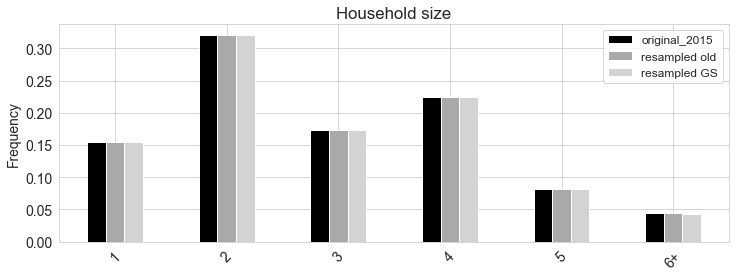

In [126]:
for df in dfs_hh:
    df['hsize_new'] = df.hsize.apply(lambda x: 6 if x >= 6 else x)

plot_marginals(dfs_hh, 'hsize_new', ["1","2","3","4","5","6+"], addtitle="Household size", save=True)

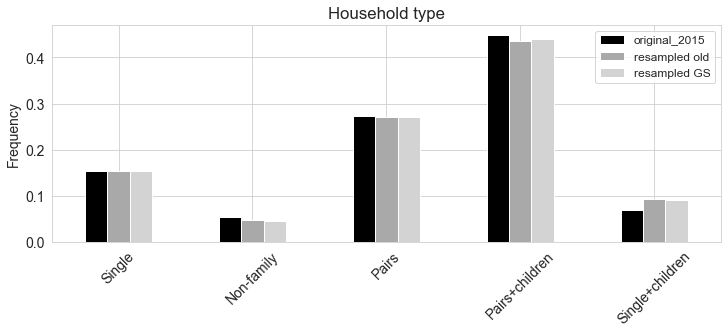

In [33]:
plot_marginals(dfs_hh,'htype',['Single', 'Non-family', 'Pairs', 'Pairs+children', 'Single+children'], addtitle="Household type")

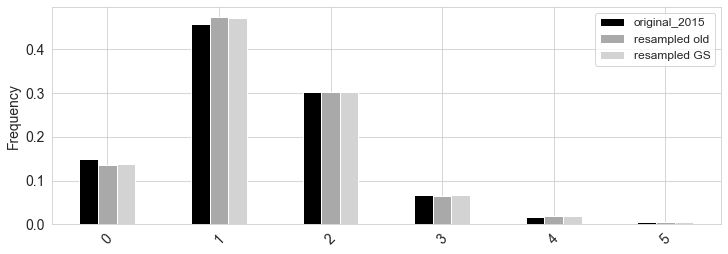

In [34]:
plot_marginals(dfs_hh, 'nbcars_agg', [0,1,2,3,4,5])

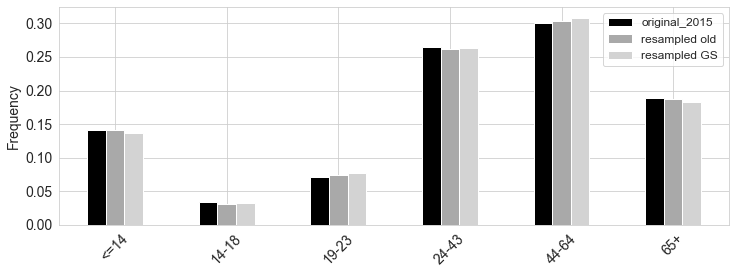

In [35]:
plot_marginals(dfs_hh, 'age_discrete', ["<=14","14-18","19-23","24-43","44-64","65+"])

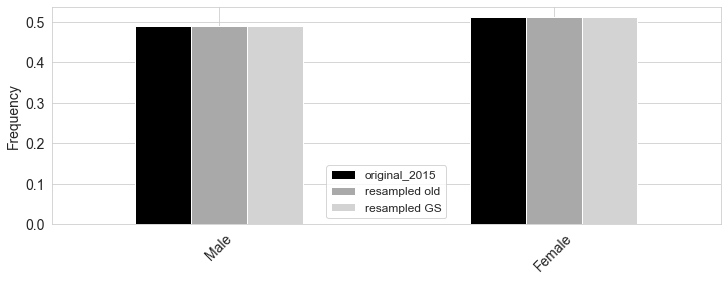

In [36]:
plot_marginals(dfs_hh, 'gender', ["Male","Female"])

# Resampling GS and projection

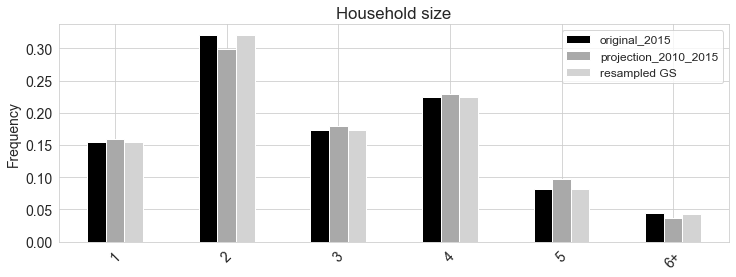

In [13]:
for df in dfs_hh:
    df['hsize_new'] = df.hsize.apply(lambda x: 6 if x >= 6 else x)

plot_marginals(dfs_hh, 'hsize_new', ["1","2","3","4","5","6+"], addtitle="Household size", save=True)

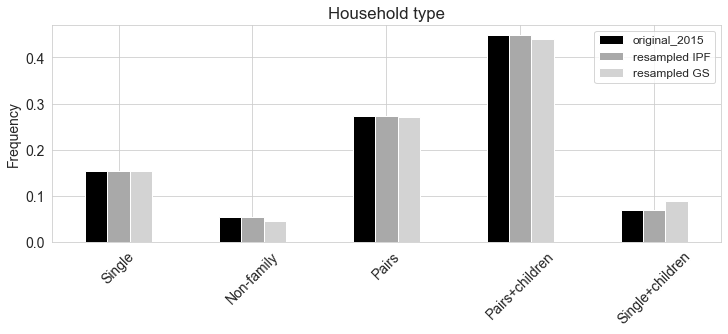

In [119]:
plot_marginals(dfs_hh,'htype',['Single', 'Non-family', 'Pairs', 'Pairs+children', 'Single+children'], addtitle="Household type")

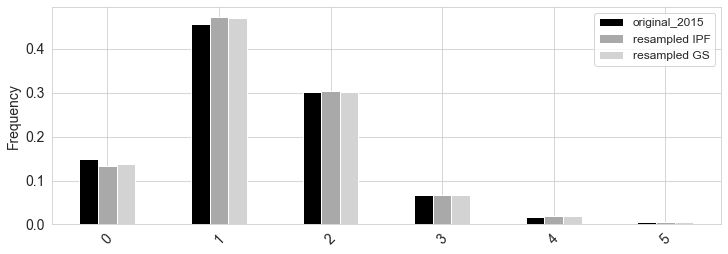

In [120]:
plot_marginals(dfs_hh, 'nbcars_agg', [0,1,2,3,4,5])

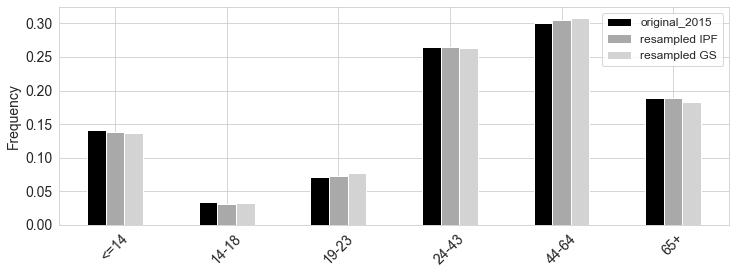

In [121]:
plot_marginals(dfs_hh, 'age_discrete', ["<=14","14-18","19-23","24-43","44-64","65+"])

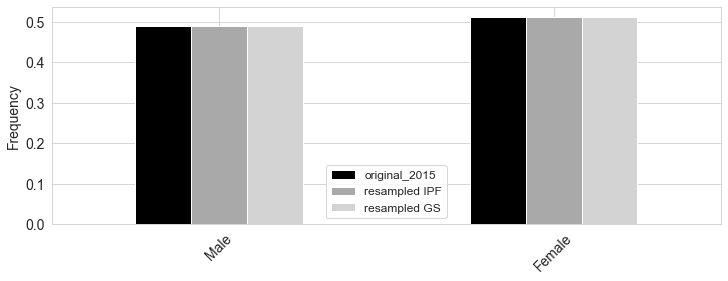

In [122]:
plot_marginals(dfs_hh, 'gender', ["Male","Female"])

In [20]:
gs = pd.read_csv("resampled_2015_GS.csv")
ipf = pd.read_csv("resampled_2015_htype.csv")

In [10]:
gs = pd.read_csv("resampled_2015_GS.csv")
pred = pd.read_csv("results/proj2/predictive_sample_2015.csv")

In [11]:
indiv_2015 = pd.read_csv("data/indiv_rw_2015.csv")
attributes = ["marital_status","employment"]
indiv_2015 = indiv_2015[attributes].copy()
gs_2015 = gs[attributes].copy()
pred_2015 = pred[attributes].copy()

In [12]:
results1 = stats_assessment(gs_2015, indiv_2015, aggregation_level=1)
df_results1 = pd.DataFrame(results1)
df_results1

,marital_status,employment
mae,0.011884,0.019462
rmse,0.015797,0.026161
srmse,0.078983,0.130803
r2,0.993443,0.980442
corr,0.996893,0.994564


In [13]:
results1 = stats_assessment(pred_2015, indiv_2015, aggregation_level=1)
df_results1 = pd.DataFrame(results1)
df_results1

,marital_status,employment
mae,0.016503,0.022854
rmse,0.019701,0.031973
srmse,0.078803,0.159865
r2,0.989040,0.969323
corr,0.994939,0.992155


In [14]:
gs = pd.read_csv("resampled_2015_GS.csv")
pred = pd.read_csv("results/proj2/predictive_sample_2015.csv")

In [15]:
attributes = ["htype",'hsize',"nbcars_agg","gender","age_discrete","driving_licence"]
real_2015 = reference_data_2015[attributes].copy()
gs_2015 = gs[attributes].copy()
pred = pred[attributes].copy()

In [16]:
results1 = stats_assessment(pred, real_2015, aggregation_level=1)
df_results1 = pd.DataFrame(results1)
df_results1

,nbcars_agg,driving_licence,htype,hsize,age_discrete,gender
mae,0.003941,0.047744,0.012327,0.004760,0.003726,0.000684
rmse,0.006937,0.047744,0.015651,0.007904,0.004163,0.000684
srmse,0.062434,0.095487,0.078255,0.102751,0.024979,0.001368
r2,0.998076,0.852053,0.987923,0.993883,0.998109,0.996251
corr,0.999230,1.000000,0.994557,0.997181,0.999077,1.000000


In [17]:
results1 = stats_assessment(gs_2015, real_2015, aggregation_level=1)
df_results1 = pd.DataFrame(results1)
df_results1

,nbcars_agg,driving_licence,htype,hsize,age_discrete,gender
mae,0.003639,0.030431,0.008494,0.001293,0.004399,0.000379
rmse,0.006268,0.030431,0.011091,0.002273,0.005066,0.000462
srmse,0.056413,0.060862,0.055454,0.029551,0.030396,0.001385
r2,0.998426,0.953709,0.993834,0.999517,0.997309,0.999996
corr,0.999389,1.000000,0.997727,0.999767,0.998733,0.999998


In [136]:
results1 = stats_assessment(ipf_2015, real_2015, aggregation_level=3)
df_results1 = pd.DataFrame(results1)
df_results1

,htype::driving_licence::hsize,htype::driving_licence::nbcars_agg,htype::driving_licence::gender,htype::driving_licence::age_discrete,htype::hsize::nbcars_agg,htype::hsize::gender,htype::hsize::age_discrete,htype::nbcars_agg::gender,htype::nbcars_agg::age_discrete,htype::gender::age_discrete,driving_licence::hsize::nbcars_agg,driving_licence::hsize::gender,driving_licence::hsize::age_discrete,driving_licence::nbcars_agg::gender,driving_licence::nbcars_agg::age_discrete,driving_licence::gender::age_discrete,hsize::nbcars_agg::gender,hsize::nbcars_agg::age_discrete,hsize::gender::age_discrete,nbcars_agg::gender::age_discrete
mae,0.002038,0.002316,0.006511,0.003181,0.001023,0.001389,0.000769,0.001736,0.001094,0.001328,0.001167,0.002493,0.001516,0.003480,0.002802,0.008214,0.000874,0.000547,0.000610,0.001368
rmse,0.003912,0.004623,0.008409,0.005267,0.002206,0.002330,0.001547,0.003163,0.002262,0.001985,0.002676,0.004268,0.002892,0.007475,0.004779,0.010281,0.001686,0.001420,0.001298,0.002409
srmse,0.230794,0.328218,0.168181,0.247554,0.337458,0.139775,0.244411,0.230864,0.391309,0.107180,0.363932,0.221913,0.323864,0.246663,0.348869,0.205618,0.234330,0.498257,0.180391,0.214397
r2,0.989615,0.970561,0.961774,0.971280,0.986724,0.995147,0.991362,0.982943,0.964888,0.991048,0.977141,0.979646,0.975394,0.970418,0.964314,0.940198,0.987782,0.964834,0.990379,0.980887
corr,0.994954,0.985543,0.981698,0.985577,0.993408,0.997583,0.995686,0.991504,0.982472,0.995525,0.989699,0.990063,0.987636,0.986007,0.982649,0.971022,0.993904,0.982791,0.995212,0.990397


### Resampling htype changed to hsize - old - random choice

In [22]:
def resample_att(difference_count, synthetic_data):
    
    resulting_data = synthetic_data
    for i in range(len(difference_count)):
        print(f'Iteration number:{i}')
        #deleting case
        if((difference_count["Counts_real"][i] - difference_count["Counts_projected"][i])<0):
                nb_obs = abs(difference_count["Counts_real"][i] - difference_count["Counts_projected"][i])
                hsize = difference_count["hsize_new"][i]
                if(hsize == 1): #single households you can add or delete nothing happens
                    print(f'Single households; deleting: {nb_obs}; size: {len(resulting_data)}')
                    for j in range(nb_obs):
                        resulting_data.drop(np.random.choice(resulting_data[(resulting_data['hsize_new']==hsize)].index), inplace=True)
                    print(f'size after:{len(resulting_data)}')
                else:#other households
                    #select the whole household and calculate the difference
                    iteration = nb_obs
                    print(f'Hsize: {hsize}; delete {iteration}; size {len(resulting_data)}')
                    while(iteration>=0):
                        index = np.random.choice(resulting_data[(resulting_data['hsize_new']==hsize)].index)
                        hid = resulting_data.iloc[index]['hid']
                        household_df = resulting_data[resulting_data['hid']==hid]
                        size = len(household_df)
                        #ovde moze da se doda provera da ne bi obrisao manje ili vise observacija nego sto treba
                        #npr. if size<=iteration: ovaj kod ispod else: obrisi toliko koliko treba; iteration = 0
                        resulting_data = resulting_data.drop(household_df.index).reset_index(drop=True)
                        iteration = iteration - size 
                    print(f'size after:{len(resulting_data)}')
        #adding case            
        else:
            nb_obs = abs(difference_count["Counts_real"][i] - difference_count["Counts_projected"][i])
            hsize = difference_count["hsize_new"][i]
            if(hsize == 1):
                print(f'Single households; adding: {nb_obs}; size: {len(resulting_data)}')
                for j in range(nb_obs):
                    row =  resulting_data[(resulting_data['hsize_new'] == hsize)].sample().squeeze()
                    resulting_data = resulting_data.append(row, ignore_index=True)
                print(f'size after:{len(resulting_data)}')
            else:#za sada duplikate koristim, a inace bi trebalo da se sampluje
                iteration = nb_obs
                print(f'Hsize: {hsize}; adding {iteration}; size {len(resulting_data)}')
                while(iteration>=0):
                    index = np.random.choice(resulting_data[(resulting_data['hsize_new']==hsize)].index)
                    hid = resulting_data.iloc[index]['hid']
                    household_df = resulting_data[resulting_data['hid']==hid]
                    size = len(household_df)
                    resulting_data = pd.concat([resulting_data,household_df],ignore_index=True)
                    iteration = iteration - size 
                print(f'size after:{len(resulting_data)}')
        print('---------------------------------------------------------------------------------------------')
    return resulting_data

In [23]:
merged_df#brisemo ceo householod, ali nisam sigurna da li brisemo vise nego sto treba, jer na kraju ovde dobijemo isti broj households

,hsize_new,Counts_projected,Counts_real,Prob_projected,Prob_real
0,1,23287,19373,0.158911,0.154192
1,2,43760,40286,0.298619,0.320641
2,3,26397,21786,0.180134,0.173397
3,4,33620,28228,0.229424,0.224670
4,5,14195,10320,0.096867,0.082138
5,6,5282,5649,0.036045,0.044961


In [24]:
resampled_age_type = resample_att(merged_df, projection_2010_2015)

Iteration number:0
Single households; deleting: 3914; size: 146541
size after:142627
---------------------------------------------------------------------------------------------
Iteration number:1
Hsize: 2; delete 3474; size 142627
size after:139151
---------------------------------------------------------------------------------------------
Iteration number:2
Hsize: 3; delete 4611; size 139151
size after:134537
---------------------------------------------------------------------------------------------
Iteration number:3
Hsize: 4; delete 5392; size 134537
size after:129141
---------------------------------------------------------------------------------------------
Iteration number:4
Hsize: 5; delete 3875; size 129141
size after:125261
---------------------------------------------------------------------------------------------
Iteration number:5
Hsize: 6; adding 367; size 125261
size after:125630
--------------------------------------------------------------------------------------

In [29]:
resampled_age_type.to_csv("hsize_resample_old.csv", index = False)

## Resampling always the same individual - hardcore randomly chosen indivdiual that you want and delete or add as many times

In [44]:
projection_2010_2015[projection_2010_2015['hsize']==3]['htype'].value_counts().sort_index()

30      1335
220    17847
230     7215
Name: htype, dtype: int64

In [45]:
projection_2010_2015

,hid,htype,nbcars_agg,hsize,age_discrete,gender,marital_status,employment,driving_licence,age,role,hsize_new
0,0,10,1,1,6,2,3,4,1,71,1,1
1,1,10,1,1,6,2,3,4,1,76,1,1
2,3,10,0,1,6,2,3,4,2,87,1,1
4,7,10,0,1,6,2,3,4,2,70,1,1
5,8,10,0,1,6,2,3,4,2,82,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
146534,73136,10,1,1,3,2,1,3,1,23,1,1
146536,73138,10,1,1,4,2,1,2,2,26,1,1
146537,73139,10,1,1,4,2,1,1,2,28,1,1
146538,73140,10,1,1,4,2,1,2,2,24,1,1


In [50]:
projection_2010_2015[(projection_2010_2015['hsize_new']==1) & (projection_2010_2015['htype']==10) & (projection_2010_2015['nbcars_agg']==1)]

,hid,htype,nbcars_agg,hsize,age_discrete,gender,marital_status,employment,driving_licence,age,role,hsize_new
0,0,10,1,1,6,2,3,4,1,71,1,1
1,1,10,1,1,6,2,3,4,1,76,1,1
15,21,10,1,1,5,2,2,2,1,62,1,1
16,22,10,1,1,6,2,2,4,1,83,1,1
19,27,10,1,1,6,2,3,4,1,83,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
146534,73136,10,1,1,3,2,1,3,1,23,1,1
146536,73138,10,1,1,4,2,1,2,2,26,1,1
146537,73139,10,1,1,4,2,1,1,2,28,1,1
146538,73140,10,1,1,4,2,1,2,2,24,1,1


In [114]:
#1 1 10 -> za pocetak sam samo ovo obrisala
#2 210 1
#3 220 1
#4 220 1
#5 220 1
#6 220 1

def resample_selected(difference_count, synthetic_data):
    cnt = 0
    resulting_data = synthetic_data
    for i in range(len(difference_count)):
        print(f'Iteration number:{i}')
        #deleting case
        if((difference_count["Counts_real"][i] - difference_count["Counts_projected"][i])<0):
                nb_obs = abs(difference_count["Counts_real"][i] - difference_count["Counts_projected"][i])
                hsize = difference_count["hsize_new"][i]
                if(hsize == 1): #single households you can add or delete nothing happens
                    print(f'Single households; deleting: {nb_obs}; size: {len(resulting_data)}')
                    for j in range(nb_obs):
                        cnt += 1
                        resulting_data.drop(np.random.choice(resulting_data[(resulting_data['hsize_new']==hsize) & (resulting_data['htype']==10) & (resulting_data['nbcars_agg']==1)].index), inplace=True)
                    print(f'size after:{len(resulting_data)}')
                else:#other households
                    #select the whole household and calculate the difference
                    iteration = nb_obs
                    print(f'Hsize: {hsize}; delete {iteration}; size {len(resulting_data)}')
                    while(iteration>=0):
                        if(hsize==2):
                            index = np.random.choice(resulting_data[(resulting_data['hsize_new']==hsize) & (resulting_data['htype']==210) & (resulting_data['nbcars_agg']==1)].index)
                            hid = resulting_data.iloc[index]['hid']
                            household_df = resulting_data[resulting_data['hid']==hid]
                            size = len(household_df)
                        #ovde moze da se doda provera da ne bi obrisao manje ili vise observacija nego sto treba
                        #npr. if size<=iteration: ovaj kod ispod else: obrisi toliko koliko treba; iteration = 0
                            resulting_data = resulting_data.drop(household_df.index).reset_index(drop=True)
                            iteration = iteration - size 
                        else:
                            index = np.random.choice(resulting_data[(resulting_data['hsize_new']==hsize)].index)
                            hid = resulting_data.iloc[index]['hid']
                            household_df = resulting_data[resulting_data['hid']==hid]
                            size = len(household_df)
                        #ovde moze da se doda provera da ne bi obrisao manje ili vise observacija nego sto treba
                        #npr. if size<=iteration: ovaj kod ispod else: obrisi toliko koliko treba; iteration = 0
                            resulting_data = resulting_data.drop(household_df.index).reset_index(drop=True)
                            iteration = iteration - size 
                print(f'size after:{len(resulting_data)}')
        #adding case            
        else:
            nb_obs = abs(difference_count["Counts_real"][i] - difference_count["Counts_projected"][i])
            hsize = difference_count["hsize_new"][i]
            if(hsize == 1):
                print(f'Single households; adding: {nb_obs}; size: {len(resulting_data)}')
                for j in range(nb_obs):
                    row =  resulting_data[(resulting_data['hsize_new'] == hsize)  & (resulting_data['htype']==10) & (resulting_data['nbcars_agg']==1)].sample().squeeze()
                    resulting_data = resulting_data.append(row, ignore_index=True)
                print(f'size after:{len(resulting_data)}')
            else:#za sada duplikate koristim, a inace bi trebalo da se sampluje
                iteration = nb_obs
                print(f'Hsize: {hsize}; adding {iteration}; size {len(resulting_data)}')
                while(iteration>=0):
                    index = np.random.choice(resulting_data[(resulting_data['hsize_new']==hsize)].index)
                    hid = resulting_data.iloc[index]['hid']
                    household_df = resulting_data[resulting_data['hid']==hid]
                    size = len(household_df)
                    resulting_data = pd.concat([resulting_data,household_df],ignore_index=True)
                    iteration = iteration - size 
                print(f'size after:{len(resulting_data)}')
        print(f'Obrisano koliko observacija:{cnt}')
        print('---------------------------------------------------------------------------------------------')
    return resulting_data

In [115]:
resampled_age_type_selected = resample_selected(merged_df, projection_2010_2015)

Iteration number:0
Single households; deleting: 3914; size: 146541
size after:142627
size after:142627
Obrisano koliko observacija:3914
---------------------------------------------------------------------------------------------
Iteration number:1
Hsize: 2; delete 3474; size 142627
size after:139151
Obrisano koliko observacija:3914
---------------------------------------------------------------------------------------------
Iteration number:2
Hsize: 3; delete 4611; size 139151
size after:134537
Obrisano koliko observacija:3914
---------------------------------------------------------------------------------------------
Iteration number:3
Hsize: 4; delete 5392; size 134537
size after:129141
Obrisano koliko observacija:3914
---------------------------------------------------------------------------------------------
Iteration number:4
Hsize: 5; delete 3875; size 129141
size after:125261
Obrisano koliko observacija:3914
--------------------------------------------------------------------

In [116]:
resampled_age_type_selected.to_csv("hsize_resampled_selected_1.csv", index = False)

In [117]:
def calculate_avg_srmse(df):
    # Calculate the average of the 'srmse' row
    avg_srmse = df.loc['srmse'].mean()
    
    return avg_srmse

In [118]:
gs = pd.read_csv("resampled_2015_GS.csv")
ipf = pd.read_csv("hsize_resampled_selected.csv") # selected je samo single, a selected_1 je i kad obrisem jos iz parova
ipf1 = pd.read_csv("hsize_resampled_selected_1.csv")

In [119]:
attributes = ["htype",'hsize',"nbcars_agg","gender","age_discrete","driving_licence"]
real_2015 = reference_data_2015[attributes].copy()
gs_2015 = gs[attributes].copy()
ipf = ipf[attributes].copy()
ipf1 = ipf1[attributes].copy()

## GS resampling and real data

In [94]:
results1 = stats_assessment(gs_2015, real_2015, aggregation_level=1)
df_results1 = pd.DataFrame(results1)
print(df_results1)
calculate_avg_srmse(df_results1)

       driving_licence     htype    gender  nbcars_agg     hsize  age_discrete
mae           0.030431  0.008494  0.000379    0.003639  0.001293      0.004399
rmse          0.030431  0.011091  0.000462    0.006268  0.002273      0.005066
srmse         0.060862  0.055454  0.001385    0.056413  0.029551      0.030396
r2            0.953709  0.993834  0.999996    0.998426  0.999517      0.997309
corr          1.000000  0.997727  0.999998    0.999389  0.999767      0.998733


0.03901007896356729

In [95]:
results1 = stats_assessment(gs_2015, real_2015, aggregation_level=2)
df_results1 = pd.DataFrame(results1)
print(df_results1)
calculate_avg_srmse(df_results1)

       driving_licence::htype  driving_licence::gender  \
mae                  0.008468                 0.019694   
rmse                 0.010409                 0.025884   
srmse                0.104094                 0.129421   
r2                   0.984323                 0.952257   
corr                 0.993744                 0.980644   

       driving_licence::nbcars_agg  driving_licence::hsize  \
mae                       0.006286                0.002854   
rmse                      0.009930                0.003951   
srmse                     0.168810                0.102718   
r2                        0.986672                0.995590   
corr                      0.993803                0.997924   

       driving_licence::age_discrete  htype::gender  htype::nbcars_agg  \
mae                         0.011472       0.004590           0.002681   
rmse                        0.014417       0.005909           0.005096   
srmse                       0.144172       0.065003     

0.1233064805988274

In [97]:
results1 = stats_assessment(gs_2015, real_2015, aggregation_level=3)
df_results1 = pd.DataFrame(results1)
print(df_results1)
calculate_avg_srmse(df_results1)

       driving_licence::htype::gender  driving_licence::htype::nbcars_agg  \
mae                          0.005975                            0.002250   
rmse                         0.007654                            0.004319   
srmse                        0.160742                            0.315296   
r2                           0.966914                            0.972323   
corr                         0.985697                            0.987472   

       driving_licence::htype::hsize  driving_licence::htype::age_discrete  \
mae                         0.001838                              0.003181   
rmse                        0.003305                              0.004773   
srmse                       0.201582                              0.233868   
r2                          0.992158                              0.973850   
corr                        0.996560                              0.987987   

       driving_licence::gender::nbcars_agg  driving_licence::gender:

0.2556622581076473

## Selection of same single households resampling and real

In [127]:
results1 = stats_assessment(ipf, real_2015, aggregation_level=1)
df_results1 = pd.DataFrame(results1)
print(df_results1)
calculate_avg_srmse(df_results1)

       driving_licence     htype    gender  nbcars_agg     hsize  age_discrete
mae           0.046882  0.010155  0.002241    0.001124  0.000756      0.002169
rmse          0.046882  0.013400  0.002241    0.001267  0.001568      0.002411
srmse         0.093764  0.067001  0.004483    0.010136  0.020384      0.014463
r2            0.859303  0.990769  0.969006    0.999937  0.999769      0.999376
corr          1.000000  0.996859  1.000000    0.999973  0.999885      0.999689


0.03503852279672091

In [121]:
results1 = stats_assessment(ipf1, real_2015, aggregation_level=2)
df_results1 = pd.DataFrame(results1)
print(df_results1)
calculate_avg_srmse(df_results1)

       driving_licence::htype  driving_licence::gender  \
mae                  0.012505                 0.024339   
rmse                 0.015392                 0.033705   
srmse                0.153916                 0.134821   
r2                   0.964006                 0.707113   
corr                 0.985989                 0.960446   

       driving_licence::nbcars_agg  driving_licence::hsize  \
mae                       0.006167                0.003853   
rmse                      0.013375                0.006156   
srmse                     0.227375                0.160049   
r2                        0.973836                0.989094   
corr                      0.989786                0.994943   

       driving_licence::age_discrete  htype::gender  htype::nbcars_agg  \
mae                         0.011821       0.006810           0.004700   
rmse                        0.017282       0.008094           0.007698   
srmse                       0.172821       0.080935     

0.1574386454426781

In [122]:
results1 = stats_assessment(ipf1, real_2015, aggregation_level=3)
df_results1 = pd.DataFrame(results1)
print(df_results1)
calculate_avg_srmse(df_results1)

       driving_licence::htype::gender  driving_licence::htype::nbcars_agg  \
mae                          0.007745                            0.002907   
rmse                         0.009661                            0.005856   
srmse                        0.193217                            0.427461   
r2                           0.943808                            0.947478   
corr                         0.977209                            0.976686   

       driving_licence::htype::hsize  driving_licence::htype::age_discrete  \
mae                         0.002520                              0.003684   
rmse                        0.004826                              0.005738   
srmse                       0.294409                              0.269666   
r2                          0.982642                              0.963571   
corr                        0.992764                              0.982676   

       driving_licence::gender::nbcars_agg  driving_licence::gender:

0.3192874760691641

In [ ]:
## 0.03503852279672091, 0.1433487488504492,0.29623883802905754

### Merging data for scenario testing -low low

In [10]:
projection_2010_2015_ig = pd.read_csv('results/quality_samples/projection_2010_2015_low_both.csv')
add_data = pd.read_csv('results/quality_samples/resampling_low_low.csv')
projection_2010_2015_concat = projection_2010_2015_ig
working_attributes = ["hid","htype","nbcars_agg","hsize","age_discrete","gender","marital_status","employment","driving_licence"]
projection_2010_2015_concat = projection_2010_2015_concat[working_attributes].copy()

In [11]:
add_data["hid"] = add_data["hid"]+max(projection_2010_2015_concat["hid"]) #so we don't have duplicated ids with the real data

In [13]:
final_dataset = pd.concat([projection_2010_2015_concat, add_data], ignore_index=True)

In [14]:
final_dataset.to_csv("results/quality_samples/final_low_low_ig.csv", index=False)

### Merging for scenario testing high - low

In [10]:
projection_2010_2015 = pd.read_csv('projected_2010_2015_second_paper_high.csv')
add_data = pd.read_csv('results/quality_samples/resampling_high_low.csv')
projection_2010_2015_concat = projection_2010_2015
working_attributes = ["hid","htype","nbcars_agg","hsize","age_discrete","gender","marital_status","employment","driving_licence"]
projection_2010_2015_concat = projection_2010_2015_concat[working_attributes].copy()

In [11]:
projection_2010_2015_concat

,hid,htype,nbcars_agg,hsize,age_discrete,gender,marital_status,employment,driving_licence
0,0,10,1,1,6,2,3,4,1
1,1,10,1,1,6,2,3,4,1
2,2,10,0,1,6,2,3,4,2
3,3,10,0,1,6,2,3,4,2
4,5,10,0,1,6,2,3,4,2
...,...,...,...,...,...,...,...,...,...
146520,73078,10,1,1,3,2,1,1,1
146521,73079,10,1,1,3,1,1,1,1
146522,73080,10,1,1,4,1,1,1,2
146523,73081,10,1,1,3,1,1,3,2


### Merging for scenario testing low - high

In [31]:
projection_2010_2015_ig = pd.read_csv('results/quality_samples/projection_2010_2015_low_both.csv')
additional_data = pd.read_csv('results/quality_samples/low_high_scenario_IG_additional data.csv')
projection_2010_2015_concat = projection_2010_2015
working_attributes = ["hid","htype","nbcars_agg","hsize","age_discrete","gender","marital_status","employment","driving_licence"]
projection_2010_2015_concat = projection_2010_2015_concat[working_attributes].copy()

In [33]:
projection_2010_2015_concat.to_csv('low_high_final_dataset_IG.csv', index=False)

### Primer iz rada

In [7]:
import numpy as np
import pandas as pd
import cvxpy as cp

# Function to compute added frequencies using constrained optimization
def calculate_frequencies(prob_dist_projected, prob_dist_new, counts_projected, counts_new):
    c_total = np.sum(counts_projected)
    N = len(prob_dist_new)

    M = np.diag(prob_dist_new) @ np.ones(N).reshape(-1,1) @ np.ones(N).reshape(1,-1) - np.eye(N)

    eps = 0.01
    L_inq = np.eye(N)
    r_inq = eps * np.ones(N)

    z = cp.Variable(N)

    prob = cp.Problem(cp.Minimize(1), [L_inq @ z >= r_inq, M @ z == -M @ counts_projected])
    prob.solve()

    z_array = np.squeeze(np.array(z.value))
    return np.round(z_array).astype(int)

# Inputs: projected and real counts
projected_counts = np.array([23287, 43760, 26357, 33620, 14195, 5282])
real_counts = np.array([19373, 40286, 21786, 28237, 10320, 5649])
household_sizes = np.arange(1, 7)

### STEP 1: Print projected sample
projected_total = projected_counts.sum()
projected_probs = projected_counts / projected_total
print("\n--- Step 1: Projected Sample ---")
for size, count, prob in zip(household_sizes, projected_counts, projected_probs):
    print(f"Household Size {size}: Count = {count}, Probability = {prob:.4f}")
print(f"Total Projected Count: {projected_total}")

### STEP 2: Print real sample
real_total = real_counts.sum()
real_probs = real_counts / real_total
print("\n--- Step 2: Real Sample ---")
for size, count, prob in zip(household_sizes, real_counts, real_probs):
    print(f"Household Size {size}: Count = {count}, Probability = {prob:.4f}")
print(f"Total Real Count: {real_total}")

### STEP 3: Add frequencies to match real probabilities
added_counts = calculate_frequencies(projected_probs, real_probs, projected_counts, real_counts)
augmented_counts = projected_counts + added_counts
augmented_total = augmented_counts.sum()
augmented_probs = augmented_counts / augmented_total

print("\n--- Step 3: Augmentation ---")
for size, proj, add, aug, prob in zip(household_sizes, projected_counts, added_counts, augmented_counts, augmented_probs):
    print(f"Household Size {size}: Projected = {proj}, Added = {add}, Augmented = {aug}, Aug. Prob = {prob:.4f}")
print(f"Total Augmented Count: {augmented_total}")
print(f"Difference in count from projected: {augmented_total - projected_total}")
print(f"Difference in count from real: {augmented_total - real_total}")

### STEP 4: Delete to restore original projected total size
excess_to_delete = augmented_total - projected_total
delete_share = augmented_counts / augmented_total
to_delete = np.round(delete_share * excess_to_delete).astype(int)
final_counts = augmented_counts - to_delete
final_total = final_counts.sum()
final_probs = final_counts / final_total

print("\n--- Step 4: Deletion and Final Sample ---")
for size, final_count, final_prob in zip(household_sizes, final_counts, final_probs):
    print(f"Household Size {size}: Final Count = {final_count}, Final Prob = {final_prob:.4f}")
print(f"Total Final Count: {final_total}")
print(f"Final sample size matches original projected: {final_total == projected_total}")

### STEP 5: Compare final probabilities with real
print("\n--- Step 5: Comparison Between Final and Real Probabilities ---")
for size, real_p, final_p in zip(household_sizes, real_probs, final_probs):
    print(f"Household Size {size}: Real Prob = {real_p:.4f}, Final Prob = {final_p:.4f}, Diff = {abs(real_p - final_p):.4f}")



--- Step 1: Projected Sample ---
Household Size 1: Count = 23287, Probability = 0.1590
Household Size 2: Count = 43760, Probability = 0.2987
Household Size 3: Count = 26357, Probability = 0.1799
Household Size 4: Count = 33620, Probability = 0.2295
Household Size 5: Count = 14195, Probability = 0.0969
Household Size 6: Count = 5282, Probability = 0.0361
Total Projected Count: 146501

--- Step 2: Real Sample ---
Household Size 1: Count = 19373, Probability = 0.1542
Household Size 2: Count = 40286, Probability = 0.3206
Household Size 3: Count = 21786, Probability = 0.1734
Household Size 4: Count = 28237, Probability = 0.2247
Household Size 5: Count = 10320, Probability = 0.0821
Household Size 6: Count = 5649, Probability = 0.0450
Total Real Count: 125651

--- Step 3: Augmentation ---
Household Size 1: Projected = 23287, Added = 3658, Augmented = 26945, Aug. Prob = 0.1542
Household Size 2: Projected = 43760, Added = 12272, Augmented = 56032, Aug. Prob = 0.3206
Household Size 3: Projected

C:\Users\marij\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
